# Классификация для определения, будет ли зарплата не менее 50.000
### Набор данных взят [отсюда](https://www.kaggle.com/datasets/mastmustu/income)
Датасет изначально разделен на train (для тренировки) и test (проверки модели). Файлы называются соответственно.

В данном наборе изначально дано 15 столбцов и 41.000-44.000 строк с данными для каждой фичи

## Импорт библиотек
Начало работы знаменуется импортом библиотек, которые нам понадобятся.

Документации для них:

[pandas](https://pandas.pydata.org/docs/)

[numpy](https://numpy.org/doc/stable/)

[seaborn](https://seaborn.pydata.org/)

[matplotlib](https://matplotlib.org/stable/index.html)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Затрачено времени: %i часов %i минут и %s секунд.' % (thour, tmin, round(tsec, 2)))

## Считываем данные из файла для тренировки модели

In [3]:
df = pd.read_csv("../data/train.csv")

# Предварительная обработка данных
## Проверка типов данных
Смотрим информацию о датасете, сколько записей содержится и какие типы данных у строк

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


## Убираем строки с теми данными, которые не заполнены
Сначала посмотрим, сколько таких строк у нас всего

In [5]:
df.isnull().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

Можно заметить, что число таких строк не большое относительно всего набора данных
На примере workclass: 2498 на 41459 всех записей. Поэтому такими строками можно пренебречь, убрав их.

Axis=0 уберет все строки (1 отвечает за столбцы), а inplace=True позволяет не порождать новый датафрейм, а изменять текущий

In [6]:
df.dropna(subset=["workclass", "occupation", "native-country"], axis=0, inplace=True)
df.isnull().sum() # После удаления пустых

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income_>50K        0
dtype: int64

## Дублирование строк
Не стоит забывать и о дублях некоторых записей, их тоже надо бы убрать

In [7]:
df[df.duplicated()].shape # Сколько таких строк
df.drop_duplicates(inplace=True)
df.count() # Сколько строк данных осталось

age                40686
workclass          40686
fnlwgt             40686
education          40686
educational-num    40686
marital-status     40686
occupation         40686
relationship       40686
race               40686
gender             40686
capital-gain       40686
capital-loss       40686
hours-per-week     40686
native-country     40686
income_>50K        40686
dtype: int64

## Работа с нерелевантными столбцами
### Необходимо понять, какие столбцы не будут актуальны для нас в будущем, поэтому следует рассмотреть их поближе
### Начнем с типа работы

<AxesSubplot: xlabel='count', ylabel='workclass'>

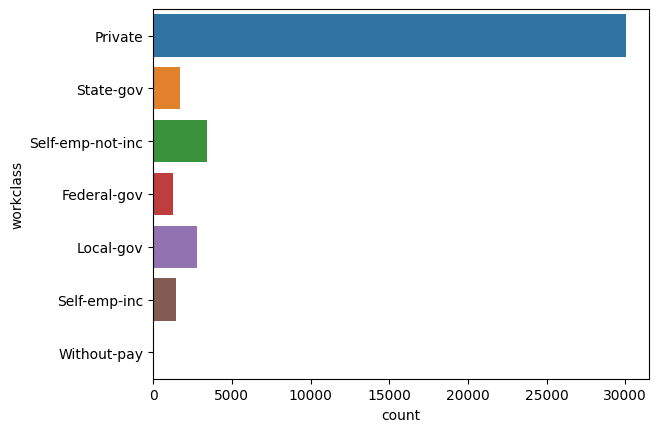

In [8]:
sns.countplot(y=df["workclass"])

In [9]:
without_pay = [row for row in df["workclass"] if row == "Without-pay"]
print(len(without_pay))

20


Категория Without-pay нас оприори не интересует, а количество таких записей вовсе мало - 20. Поэтому убираем эти данные из выборки

In [10]:
df.drop(df.index[df['workclass'] == 'Without-pay'], inplace=True)
df.shape # Смотрим, что осталось на самом деле на 20 строк меньше

(40666, 15)

### Образование
В данной выборке у нас есть 2 столбца, которые отвечают за образование:

Один имеет текстовый формат, другой - числовой. Уберем текстовый, оставим только число

In [11]:
df.drop(["education"], axis=1, inplace=True) # Исключение столбца с текстовым форматом

### Семейное положение
В данной выборке также имеется 2 различных столбца для семейного положения и отношений по отдельности.

Так как один из столбцов является аналогией другого, то один из них отбросим, а со вторым будет вестись работа.

Было выбрано убрать столбец "relationship" (отношения), оставить "marital-status" (семейное положение)

<AxesSubplot: xlabel='count', ylabel='marital-status'>

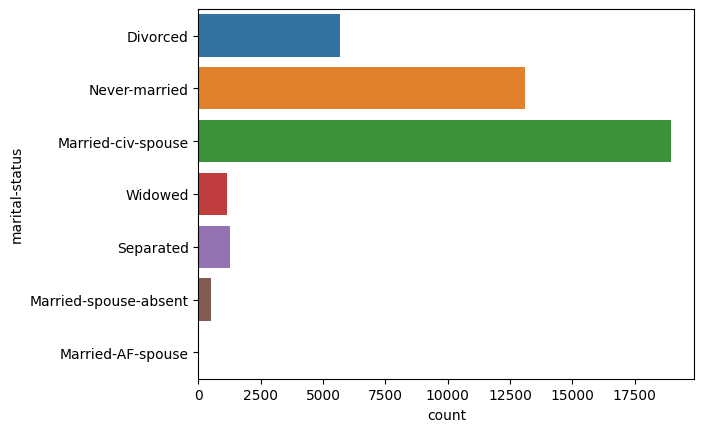

In [12]:
sns.countplot(y=df["marital-status"])

Separation means that you are living apart from your spouse but are still legally married until you get a judgment of divorce.

Все, что включает в себя слово married, кроме never-married, объединим в общую категорию "married". Separated, по описанию выше, тоже сюда входит.

Остальное - в категорию "single"

In [13]:
df["marital-status"].replace(
    ["Married-civ-spouse", "Separated", "Married-spouse-absent", "Married-AF-spouse"], 
    "married", 
    inplace=True)  # Заменяем на "married"

df["marital-status"].replace(
    ["Divorced", "Never-married", "Widowed"], 
    "single", 
    inplace=True) # Заменяем на "single"

Посмотрим на то, что вышло по итогу: сколько людей состоят в браке, а сколько - одиноки

<AxesSubplot: xlabel='count', ylabel='marital-status'>

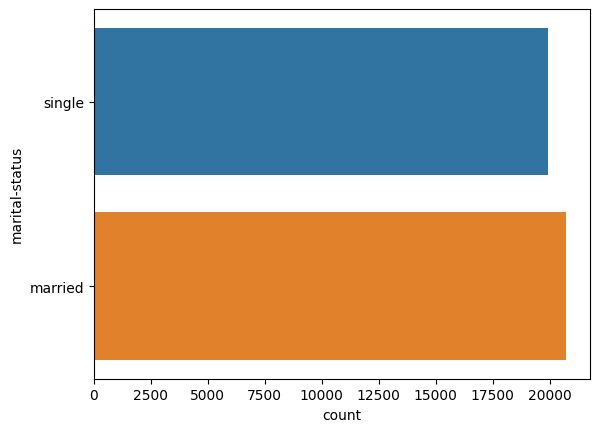

In [14]:
sns.countplot(y=df["marital-status"])

Обозначим этот столбец бинарно: 0 - одинок (-а), 1 - не одинок (-а). Это будет потом :)

Также вспомним, что у нас есть такой столбец как relationship, который теряет актуальность из-за разбиение на "одинок" и "в браке" в данном пункте, поэтому удаляем данный столбец

In [15]:
df.drop(columns='relationship', axis=1, inplace=True)

### Родная страна
Посмотрим, какие страны участвуют в выборке

<AxesSubplot: xlabel='count', ylabel='native-country'>

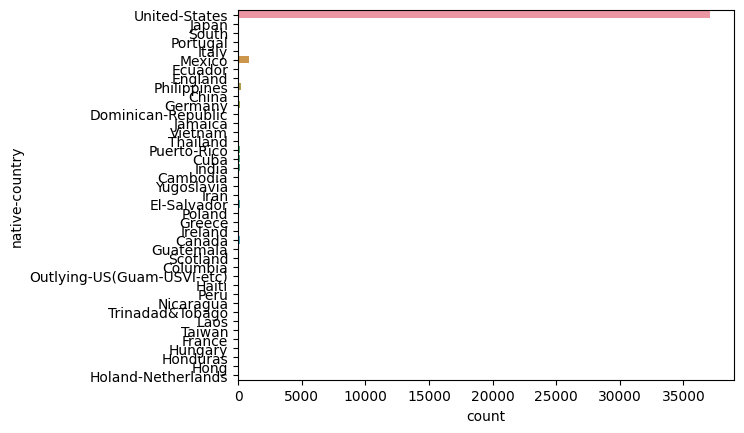

In [16]:
sns.countplot(y=df["native-country"])

Основная составляющая выборки - США. По этому можно отбросить эту фичу сразу, т.к. вклад она вносить как таковой не будет

In [17]:
df.drop(columns='native-country', axis=1, inplace=True)

# Визуализация оставшихся категориальных признаков

<AxesSubplot: xlabel='count', ylabel='race'>

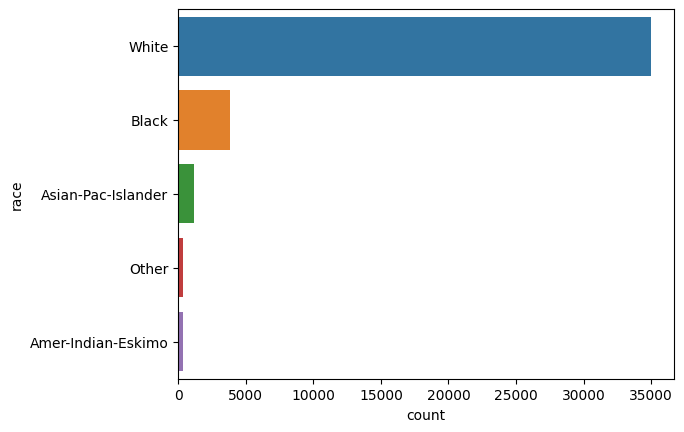

In [18]:
sns.countplot(y=df["race"])

<AxesSubplot: xlabel='count', ylabel='occupation'>

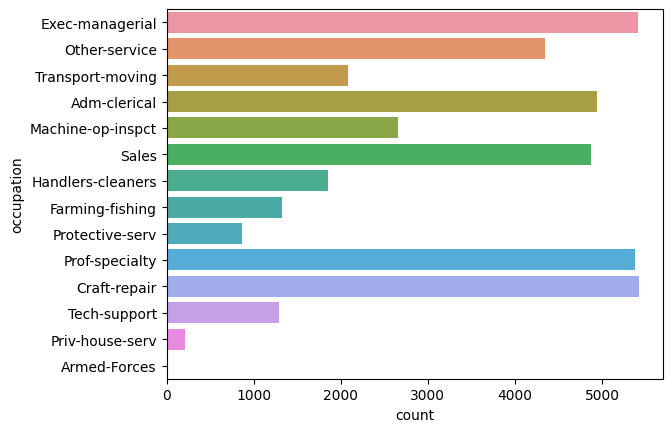

In [19]:
sns.countplot(y=df["occupation"]) # Род деятельности

## Замена категориальных признаков на числовые
Заменим категории "место работы", "род деятельности", "расу", "пол" и "семейное положение" на числовые значения.

In [20]:
print("До замены:")
print(df.info())
freq = df["workclass"].value_counts()
i = 0
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i + 1
    
i = 0
freq = df["occupation"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["race"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["gender"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["marital-status"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
print("\nПосле замены:")
print(df.info())

До замены:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40666 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              40666 non-null  int64 
 1   workclass        40666 non-null  object
 2   fnlwgt           40666 non-null  int64 
 3   educational-num  40666 non-null  int64 
 4   marital-status   40666 non-null  object
 5   occupation       40666 non-null  object
 6   race             40666 non-null  object
 7   gender           40666 non-null  object
 8   capital-gain     40666 non-null  int64 
 9   capital-loss     40666 non-null  int64 
 10  hours-per-week   40666 non-null  int64 
 11  income_>50K      40666 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 4.0+ MB
None

После замены:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40666 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           -----

# Отступление в виде наблюдений

Было замечено следующее при создании и проверки точностей моделей:

1. Столбец fnlwgt (финальный вес) ухудшает точность моделей в большинстве случаев
2. Использование SMOTE при наличии столбца fnlwgt сильно понижает точность модели, основанной на логистической прогресии, а также уменьшает точность модели К-ближайших соседей. Однако наблюдается повышение точности у других моделей
3. Удаление столбца fnlwgt перед SMOTE повышает точность всех моделей без исключения, особенно точность предсказания для класса 1

Ниже представлено сравнение моделей, если удалять столбец fnlwgt.

![Сравнение моделей при удалении fnwght](./imgs/fnlwgt_diff.png)

Можно заметить, что удаление данного столбца до SMOTE благоприятно влияет на точность моделей

Также можно применить стандартизацию данных, результат ниже

![Сравнение моделей при стандартизации и без](./imgs/std_not_std_diff.png)

Видно, что стандартизация данных благоприятно отражается на SVC и Наивном Байесовском классификаторах. На SVC __прирост в 21%__ в общем случае. Оно и понятно (см. описание классификатора)

In [21]:
df.drop(columns='fnlwgt', axis=1, inplace=True) #Повышает точность

# Проверка на сбалансированность данных

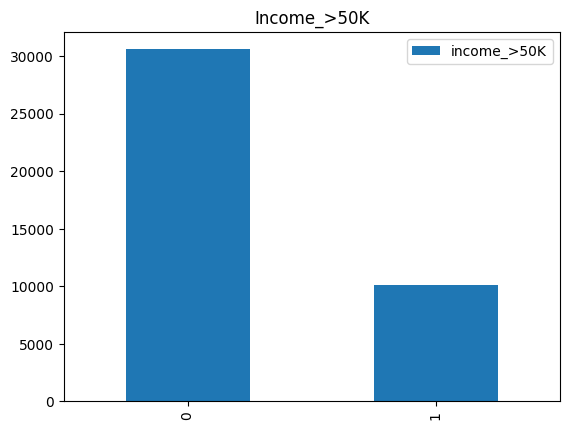

In [22]:
X = df.copy()
y = X.pop("income_>50K")

y.value_counts().plot(kind='bar', label='income_>50K')
plt.legend()
plt.title('Income_>50K');

Можно заметить, что у нас очень большой перевес в сторону того, что доход будет меньше 50.000. Если ничего не делать и оставить как есть, то в будущем модель будет плохо предсказывать класс 1.

Таким образом нам надо бы выровнять данные... Воспользуемся SMOTE. По итогу будет осуществлен процесс генерации синтетических данных, который придет выборку к сбалансированному виду на основе класса меньшинства.

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X, y = sm.fit_resample(X, y)

Посмотрим, что получилось теперь

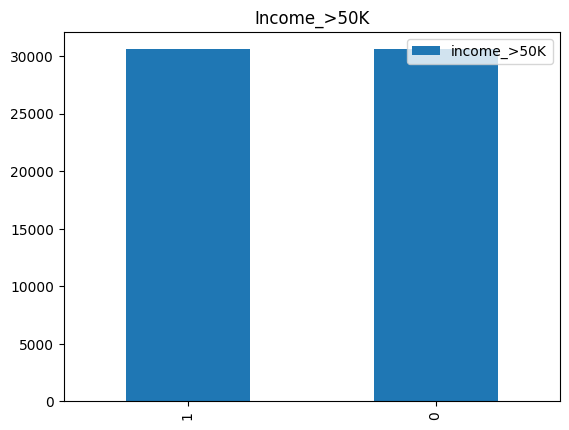

In [24]:
y.value_counts().plot(kind='bar', label='income_>50K')
plt.legend()
plt.title('Income_>50K');

Теперь данные сбалансированны, поэтому можем приступить к обучению моделей

# Если захочется проверить результат с удалением fnlwgt после SMOTE

In [25]:
#df.drop(columns='fnlwgt', axis=1, inplace=True)

## Тепловая карта
Тепловые карты - это тип графика, который необходим для поиска зависимых переменных. Один из лучших способов найти взаимосвязь между характеристиками: тепловые карты. 

,age,workclass,educational-num,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week,income_>50K
age,1.000000,0.166245,0.040624,-0.311793,-0.072004,-0.033375,-0.083774,0.078802,0.059374,0.101697,0.237614
workclass,0.166245,1.000000,0.173215,-0.092461,-0.052360,0.017842,-0.042329,0.055633,0.033317,0.080378,0.143604
educational-num,0.040624,0.173215,1.000000,-0.050131,-0.235972,-0.040176,-0.002306,0.128965,0.081023,0.148770,0.334596
marital-status,-0.311793,-0.092461,-0.050131,1.000000,0.077347,0.040875,0.391672,-0.073232,-0.068956,-0.218169,-0.410980
occupation,-0.072004,-0.052360,-0.235972,0.077347,1.000000,0.040446,0.008658,-0.057539,-0.037932,-0.065832,-0.165071
race,-0.033375,0.017842,-0.040176,0.040875,0.040446,1.000000,0.065967,-0.009190,-0.019450,-0.034901,-0.064168
gender,-0.083774,-0.042329,-0.002306,0.391672,0.008658,0.065967,1.000000,-0.046239,-0.044283,-0.231141,-0.215815
capital-gain,0.078802,0.055633,0.128965,-0.073232,-0.057539,-0.009190,-0.046239,1.000000,-0.032177,0.084666,0.221726
capital-loss,0.059374,0.033317,0.081023,-0.068956,-0.037932,-0.019450,-0.044283,-0.032177,1.000000,0.054923,0.145323
hours-per-week,0.101697,0.080378,0.148770,-0.218169,-0.065832,-0.034901,-0.231141,0.084666,0.054923,1.000000,0.227749


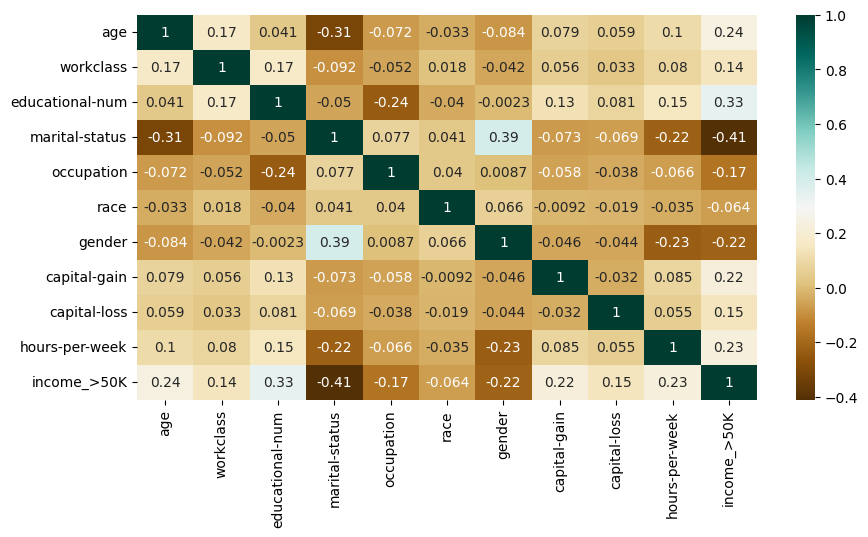

In [26]:
plt.figure(figsize=(10,5))
c = df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

# Построение модели
Обучаем модель

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

feature_names = X_train.columns

from sklearn.preprocessing import StandardScaler

sc=StandardScaler()                   # хорошо отражается на SVC и наивном байесовском классификаторе
X_train_sc=sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

## Логистическая регрессия
[Почитать тут](https://scikit-learn.ru/1-1-linear-models/#logistic-regression)

In [28]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 0, max_iter=3000)

## Дерево решений
[Статья](https://scikit-learn.ru/1-10-decision-trees/)

In [29]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

Дерево решений показало результаты лучше

## Случайный лес
Можно в этой [статье](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) узнать.

А можно на [habr](https://habr.com/ru/company/ruvds/blog/488342/)

In [30]:
from sklearn.ensemble import RandomForestClassifier

rt = RandomForestClassifier()

## К-ближайшие соседи
[Статья по этому классификатору](https://scikit-learn.ru/1-6-nearest-neighbors/)

Принцип, лежащий в основе методов ближайшего соседа, состоит в том, чтобы найти предопределенное количество обучающих выборок, ближайших по расстоянию к новой точке, и предсказать метку по ним.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

## Машина опорных векторов (SVM)
[Статья про SVM](https://scikit-learn.ru/1-4-support-vector-machines/#tips-on-practical-use)

Для данного алгоритма нужно использовать стандартизированные/нормальные данные

In [32]:
from sklearn.svm import SVC

svc = SVC()

## Наивный байесовский классификатор
[Статья](https://scikit-learn.ru/1-9-naive-bayes/#bernoulli-naive-bayes)

In [33]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.feature_names_in_ = feature_names

## Прогон всех моделей, матрица ошибок

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

models = [logreg, dt, rt, knn, svc, nb]

for model in models:
    print(model)
    if model in [svc, nb]:
        model.fit(X_train_sc, y_train.values.ravel())
        y_pred = model.predict(X_test_sc)
    else:
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred.round(0)))
    cf_matrix = confusion_matrix(y_pred.round(0), y_test)
    print(cf_matrix)
    
models = [logreg, dt, rt, knn, nb]

LogisticRegression(max_iter=3000, random_state=0)
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     10106
           1       0.80      0.86      0.83     10078

    accuracy                           0.82     20184
   macro avg       0.82      0.82      0.82     20184
weighted avg       0.82      0.82      0.82     20184

[[7888 1390]
 [2218 8688]]
DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.86      0.83      0.84     10106
           1       0.83      0.86      0.85     10078

    accuracy                           0.84     20184
   macro avg       0.84      0.84      0.84     20184
weighted avg       0.84      0.84      0.84     20184

[[8370 1410]
 [1736 8668]]
RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     10106
           1       0.85      0.89      0.87     10078

    accuracy                

Расшифровка матрицы. 

Имеет вид: 

\[\[TP TN\]

\[FN FP\]\]

T/F - True/False (В нашем случае доход >=50K или нет). P/N - Positive/Negative (Верно/Неверно)

precision - положительная прогностическая ценность. Равна отношению TP / (TP + FP)

recall - тоже смотрит отношение TP, но теперь к TP+FN

f1-score - совмещает в себе обе выше перечисленные характеристики равен 2 * (Pre\*Rec)/(Pre+Rec)

## ROC curve
[Статья](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

Идеал - левый верхний угол, но... Возможно ли это?

Чем __больше площадь__ под кривой - тем __лучше__

LogisticRegression(max_iter=3000, random_state=0)


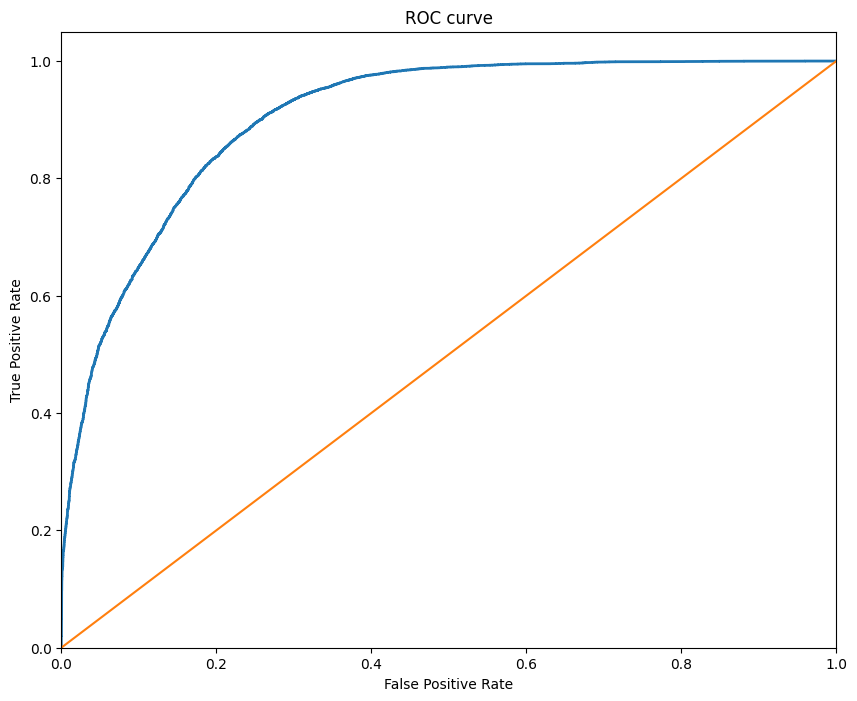

DecisionTreeClassifier()


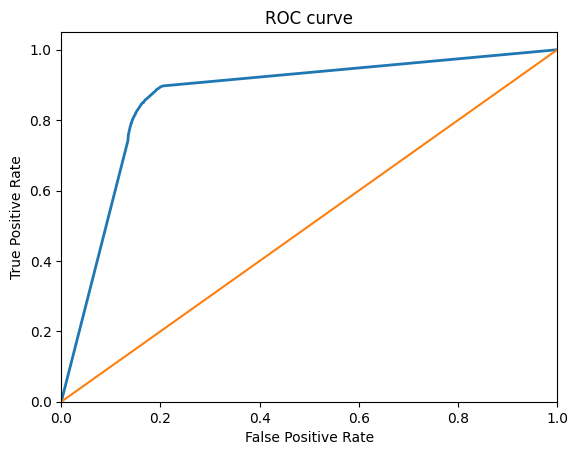

RandomForestClassifier()


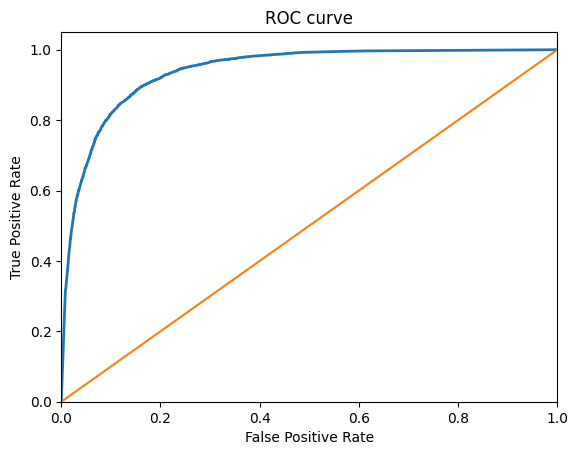

KNeighborsClassifier()


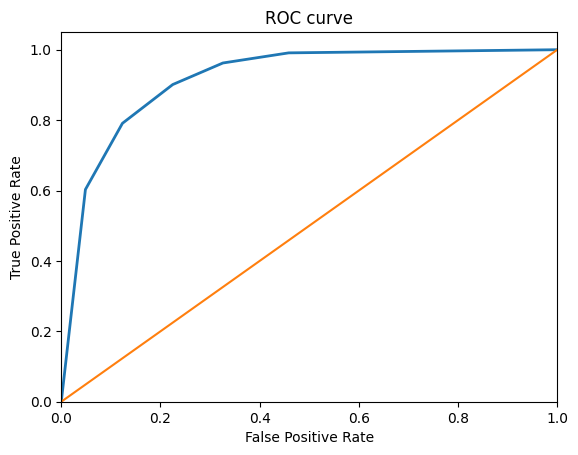

BernoulliNB()


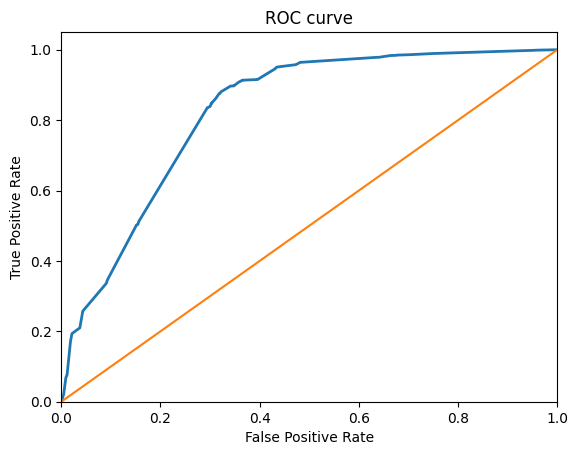

In [35]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for model in models:
    print(model)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

# Важность признаков по случайному лесу

marital-status     0.233004
age                0.220231
educational-num    0.123118
hours-per-week     0.099725
occupation         0.097225
capital-gain       0.092286
gender             0.048837
workclass          0.037524
capital-loss       0.030611
race               0.017439
dtype: float64

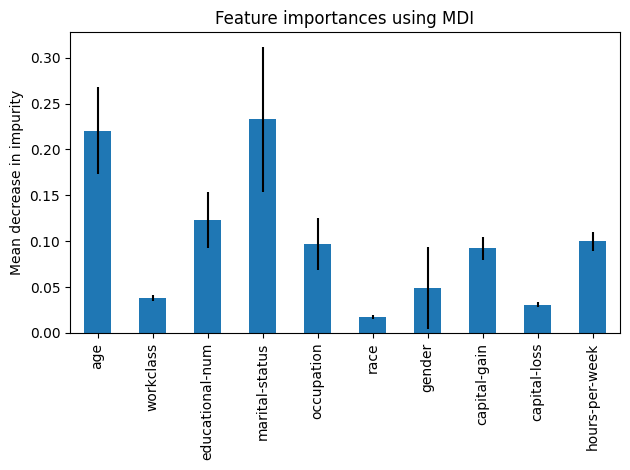

In [36]:
importances = rt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rt.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

feature_scores = pd.Series(rt.feature_importances_, index=feature_names).sort_values(ascending=False)

feature_scores

Было проведено 2 опыта: с наличием столбца fnlwgt и без него для случая, когда мы использовали SMOTE (самые лучшие результаты были именно там)

Получили следующее:

![разница признаков](../useful/rt_important.png)

Наличие столбца финального веса занижает важность образования, в то время как все остальные признаки находятся на тех же местах по важности (плюс минус 1 место)

Можно заметить, что сам финальный вес занимает 3е место по важности, однако, как показали практические опыты, модели только хуже предсказывают данные при наличии этого признака

# Визуализация дерева решений
[Отрисовка дерева написана тут](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)

In [37]:
from sklearn import tree

text_representation = tree.export_text(dt,feature_names=feature_names.tolist())
print(text_representation)

|--- marital-status <= 0.50
|   |--- educational-num <= 11.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- educational-num <= 7.50
|   |   |   |   |--- hours-per-week <= 42.50
|   |   |   |   |   |--- age <= 37.50
|   |   |   |   |   |   |--- capital-loss <= 1832.00
|   |   |   |   |   |   |   |--- capital-gain <= 3040.00
|   |   |   |   |   |   |   |   |--- workclass <= 0.50
|   |   |   |   |   |   |   |   |   |--- age <= 28.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age >  28.50
|   |   |   |   |   |   |   |   |   |   |--- age <= 33.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- age >  33.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- workclass >  0.50
|   |   |   |   |   |   |   |   |   |--- age <= 22.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   

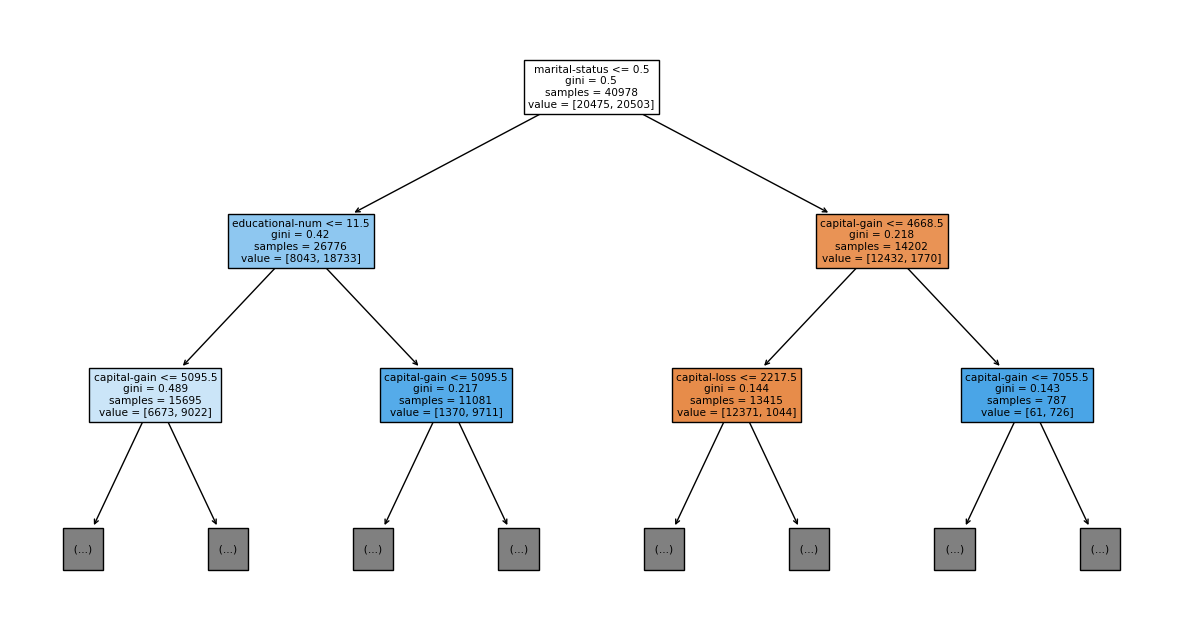

In [38]:
plt.figure(figsize=(15, 8))
tree.plot_tree(dt,
               max_depth = 2,
               feature_names = feature_names.tolist(), 
               filled = True);
plt.show()

Показатель gini больше нуля означает, что образцы, содержащиеся в этом узле, принадлежат к разным классам.

Если не указывать max_depth, то получится вот такое

![дерево решений все](./imgs/dt.png)

# GridSearch
Найдем лучшие параметры для классификаторов, а затем посмотрим результат

__Случайный лес__

In [39]:
from sklearn.model_selection import GridSearchCV

params_rfc = { 
    'random_state' : [0, 10, 100, 250, None],
    'n_estimators': [10, 50, 100, 250],  # Сколько деревьев
    'max_depth' : [5, 10, 50, None],      # Макс. глубина
    'max_features' : ["sqrt", "log2", 4] # Количество функций, которые следует учитывать при поиске лучшего разделения
}

rt=RandomForestClassifier()
random_search = GridSearchCV(estimator=rt, param_grid=params_rfc, cv=2, n_jobs=-1)
start_time = timer(None)
random_search.fit(X_train, y_train.values.ravel())
timer(start_time)
print(random_search.best_params_)
print(random_search.best_score_)
rf_bp = random_search.best_params_


 Затрачено времени: 0 часов 2 минут и 31.65 секунд.
{'max_depth': 50, 'max_features': 4, 'n_estimators': 250, 'random_state': 0}
0.8544828932597979


### Логистическая регрессия

In [ ]:
params_rfc = { 
    'max_iter' : [10, 100, 1000, 3000],
    'random_state' : [0, 10, 100, 250, None],
}

logreg = LogisticRegression()
random_search = GridSearchCV(estimator=logreg, param_grid=params_rfc, cv=2, n_jobs=-1)
start_time = timer(None)
random_search.fit(X_train, y_train.values.ravel())
timer(start_time)
print(random_search.best_params_)
print(random_search.best_score_)
rf_bp = random_search.best_params_

### Дерево решений

In [ ]:
params_rfc = { 
    'max_depth' : [5, 10, 50, None],      # Макс. глубина
    'random_state' : [0, 10, 100, 250, None],
    'splitter': ["best", "random"],
}

dt = DecisionTreeClassifier()
random_search = GridSearchCV(estimator=dt, param_grid=params_rfc, cv=2, n_jobs=-1)
start_time = timer(None)
random_search.fit(X_train, y_train.values.ravel())
timer(start_time)
print(random_search.best_params_)
print(random_search.best_score_)
rf_bp = random_search.best_params_

### К-ближайшие соседи
Веса:

‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [ ]:
params_rfc = { 
    'n_neighbors' : [2, 5, 10, 15],
    'weights': ['uniform', 'distance'],
}

knn = KNeighborsClassifier()
random_search = GridSearchCV(estimator=knn, param_grid=params_rfc, cv=2, n_jobs=-1)
start_time = timer(None)
random_search.fit(X_train, y_train.values.ravel())
timer(start_time)
print(random_search.best_params_)
print(random_search.best_score_)
rf_bp = random_search.best_params_

## Прогон после GridSearch

In [ ]:
logreg = LogisticRegression(random_state = 0, max_iter=3000)
dt = DecisionTreeClassifier(max_depth=10, random_state=100)
rt = RandomForestClassifier(max_features=4, n_estimators=250)
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

models = [logreg, dt, rt, knn]

for model in models:
    print(model)
    if model in [svc, nb]:
        model.fit(X_train_sc, y_train.values.ravel())
        y_pred = model.predict(X_test_sc)
    else:
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred.round(0)))
    cf_matrix = confusion_matrix(y_pred.round(0), y_test)
    print(cf_matrix)
    
models = [logreg, dt, rt, knn]

In [ ]:
plt.figure(figsize=(10, 8))
for model in models:
    print(model)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()